# Imoort Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error,mean_squared_error

# Load data

In [40]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
features = pd.read_csv('../data/features.csv')
stores = pd.read_csv('../data/stores.csv')

In [41]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


# Merge Datasets (Train + Features + Stores)

In [43]:
data = train.merge(features, on=['Store','Date'], how='left')
data = data.merge(stores, on='Store', how='left')

In [44]:
# Convert 'Date' column to datetime format
data['date'] = pd.to_datetime(data['Date'])

# Data Cleaning

In [45]:
# Handle missing values
data.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
date                 0
dtype: int64

In [46]:
data.fillna(method='ffill', inplace=True)

/var/folders/pv/2c7wbp5n1mbc6csyy99nrfy80000gn/T/ipykernel_63859/2866031220.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
data.isnull().sum()

# Exploratory Data Analysis

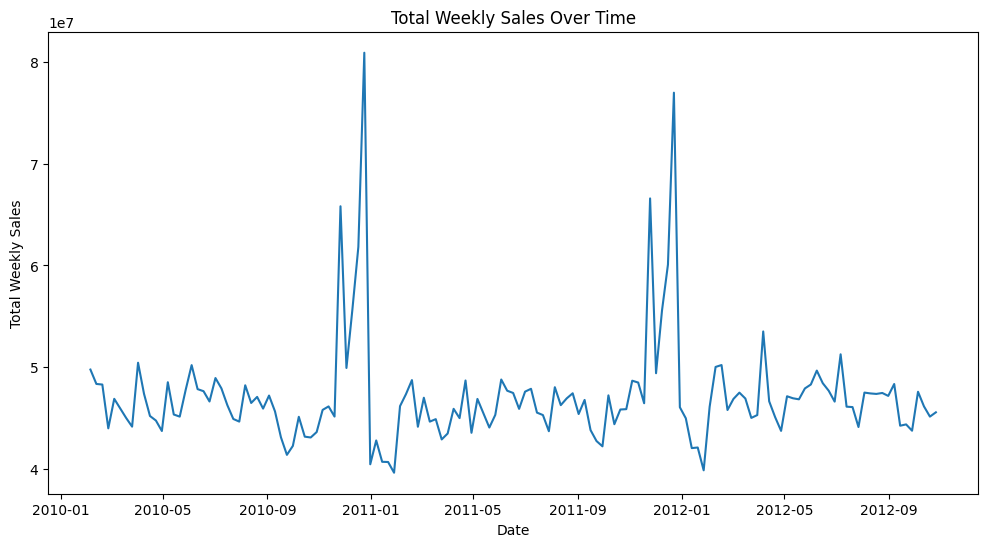

In [47]:
#Sales Trend Over Time
sales_time = data.groupby('date')['Weekly_Sales'].sum()

plt.figure(figsize=(12,6))
plt.plot(sales_time.index, sales_time.values)
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()

In [56]:
print("Columns in data:")
print(data.columns.tolist())
print("\nColumns in features:")
print(features.columns.tolist())

Columns in data:
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size', 'date']

Columns in features:
['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


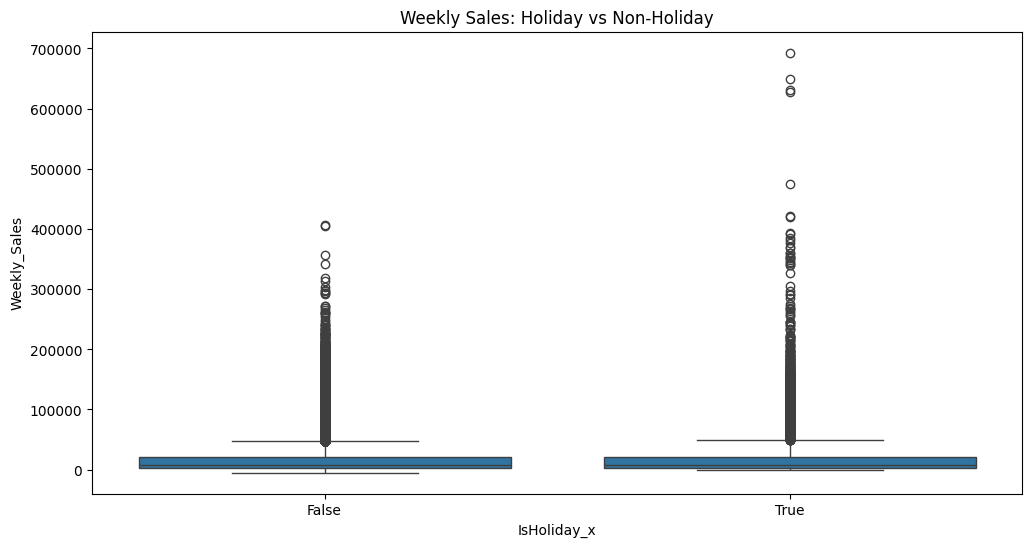

In [62]:
# Holiday vs Non-Holiday Sales
plt.figure(figsize=(12,6))
sns.boxplot(x='IsHoliday_x', y='Weekly_Sales', data=data)
plt.title('Weekly Sales: Holiday vs Non-Holiday')
plt.show()

Sales spike during holiday

# Prepare Time Series Data

In [ ]:
ts_data = data.groupby('date')['Weekly_Sales'].sum().reset_index()
ts_data.set_index('date', inplace=True)
ts_data = ts_data.asfreq('W-FRI')  # Set explicit weekly frequency

# Train-Test Split

In [64]:
train_ts = ts_data[:-12]
test_ts = ts_data[-12:]

# Build ARIMA Model

In [68]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
model = ARIMA(train_ts, order=(2,1,1))  # Reduced parameters to avoid singular matrix
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=12)

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  131
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2204.772
Date:                Thu, 15 Jan 2026   AIC                           4421.545
Time:                        17:12:17   BIC                           4438.750
Sample:                    02-05-2010   HQIC                          4428.536
                         - 08-03-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3046      0.045     -6.780      0.000      -0.393      -0.217
ar.L2         -0.2070      0.051     -4.024      0.000      -0.308      -0.106
ar.L3         -0.1806      0.063     -2.869      0.0

/Users/ahsanurrahman/Antigravity/walmart-sales-forecasting/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/ahsanurrahman/Antigravity/walmart-sales-forecasting/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/ahsanurrahman/Antigravity/walmart-sales-forecasting/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


# Evaluate Model

In [71]:
mae = mean_absolute_error(test_ts, forecast)
rmse = np.sqrt(mean_squared_error(test_ts, forecast))
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 1427328.371826452
Root Mean Squared Error: 1627515.3252262946


In [75]:
# Additional accuracy metrics
mape = np.mean(np.abs((test_ts.values.flatten() - forecast.values.flatten()) / test_ts.values.flatten())) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 3.11%


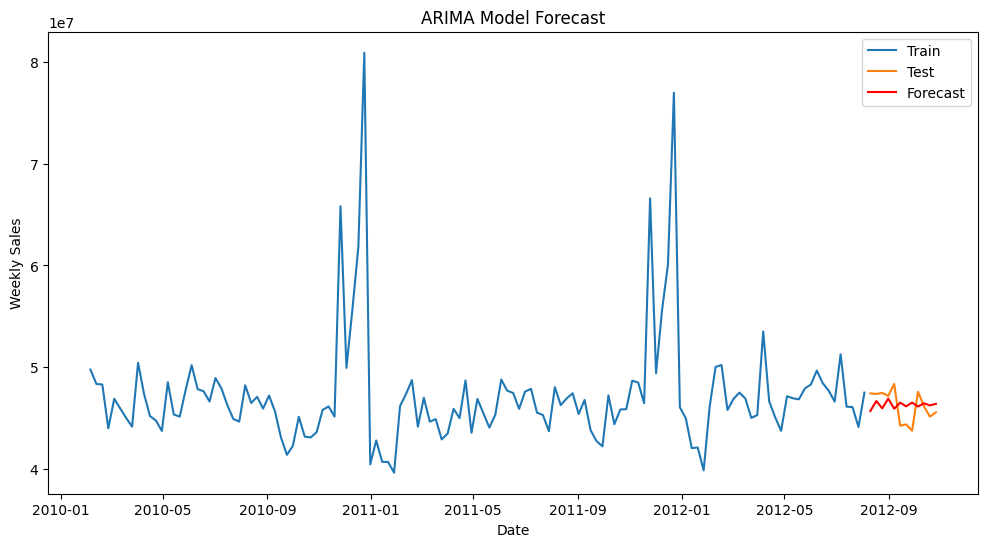

In [73]:
plt.figure(figsize=(12,6))
plt.plot(train_ts, label='Train')
plt.plot(test_ts, label='Test')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# Model Diagnostics - Check Residuals
Residuals should look like white noise (random, mean near 0)

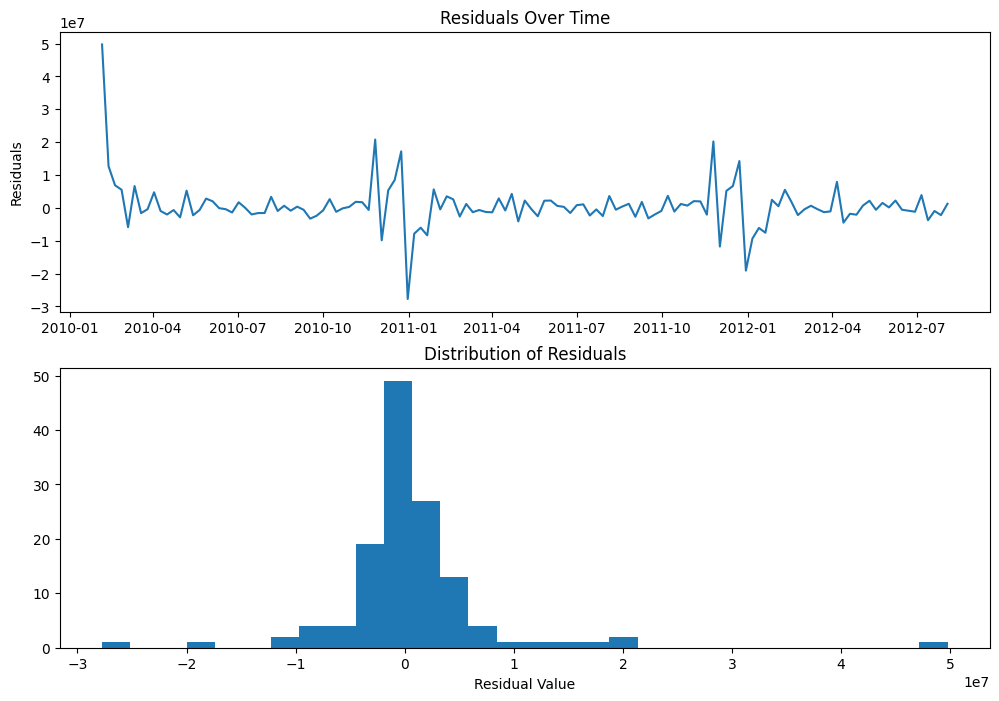

Residuals Mean: 576982.5590
Residuals Std Dev: 7088802.4717


In [79]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.ylabel('Residuals')

plt.subplot(2,1,2)
plt.hist(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.show()

print(f'Residuals Mean: {residuals.mean():.4f}')
print(f'Residuals Std Dev: {residuals.std():.4f}')

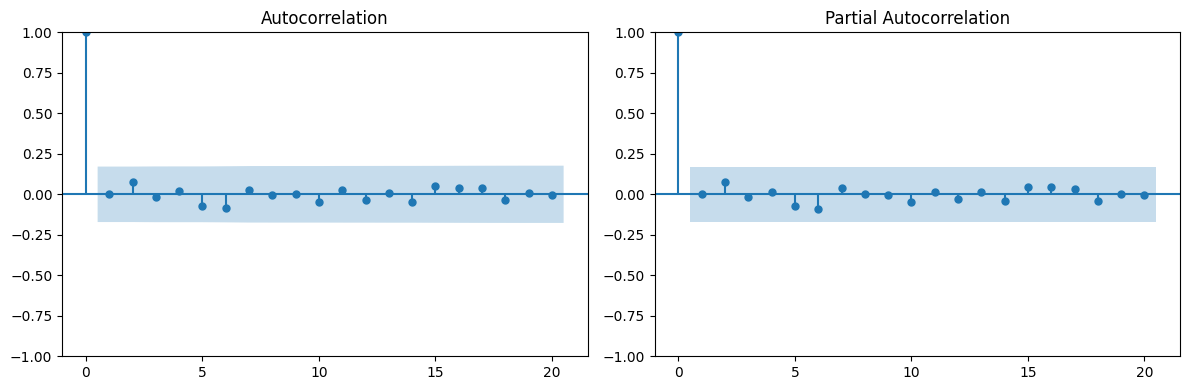

In [77]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=20)
plot_pacf(residuals, ax=ax[1], lags=20)
plt.tight_layout()
plt.show()

In [74]:
future_forecast = model_fit.forecast(steps=24)
print(future_forecast)

2012-08-10    4.567961e+07
2012-08-17    4.665379e+07
2012-08-24    4.593929e+07
2012-08-31    4.689712e+07
2012-09-07    4.589698e+07
2012-09-14    4.649613e+07
2012-09-21    4.613359e+07
2012-09-28    4.649867e+07
2012-10-05    4.611568e+07
2012-10-12    4.642930e+07
2012-10-19    4.622273e+07
2012-10-26    4.637895e+07
2012-11-02    4.622636e+07
2012-11-09    4.636506e+07
2012-11-16    4.625949e+07
2012-11-23    4.633633e+07
2012-11-30    4.627181e+07
2012-12-07    4.633068e+07
2012-12-14    4.628139e+07
2012-12-21    4.631901e+07
2012-12-28    4.628946e+07
2013-01-04    4.631485e+07
2013-01-11    4.629292e+07
2013-01-18    4.631066e+07
Freq: W-FRI, Name: predicted_mean, dtype: float64
